## Model for Multilabel Theme Classification (Fasttext + BiGRU) 

#### Imports

In [ ]:
import pandas as pd
import numpy as np

In [3]:
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Concatenate
from keras.layers import Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling1D, MaxPool1D, MaxPooling1D, SpatialDropout1D, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Input
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [ ]:
import keras

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, precision_recall_curve
import matplotlib.pyplot as plt

#### Loading the data

Using the Files tab (on the left bar), upload the following files on Collab from the data/interim/question1_models/ subdirectory of project repository:
1. embedding_matrix_fasttext.npy
2. X_train_fasttext.npy
3. X_valid_fasttext.npy
4. y_train_fasttext.npy
5. y_valid_fasttext.npy

In [ ]:
padded_docs_train = np.load('X_train_fasttext.npy')
padded_docs_valid = np.load('X_valid_fasttext.npy')
embedding_matrix_fastext = np.load('embedding_matrix_fasttext.npy')
y_train_ohe = np.load('y_train_fasttext.npy')
y_valid_ohe = np.load('y_valid_fasttext.npy')

In [10]:
padded_docs_train.shape

(20330, 432)

#### Model Building

In [ ]:
max_features = embedding_matrix_fastext.shape[0] ## vocabulary size
maxlen = padded_docs_train.shape[1]
embed_size = 300 ## for glove using 300d dataset
n_class = 12

epochs = 12
batch_size = 100

In [ ]:
def define_model(length, max_features):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(max_features, 300, weights=[embedding_matrix_fastext], trainable=False)(inputs1)

  bi_gru = Bidirectional(GRU(278, return_sequences=True))(embedding1)

  global_pool = GlobalMaxPooling1D()(bi_gru)
  avg_pool = GlobalAveragePooling1D()(bi_gru)

  concat_layer = Concatenate()([global_pool, avg_pool])

  output = Dense(n_class, activation='sigmoid')(concat_layer)

  model=Model(inputs1, output)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])
  model.summary()
  return model

In [9]:
model_gru_4 = define_model(maxlen, max_features)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 432)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 432, 300)     3468000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 432, 556)     965772      embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 556)          0           bidirectional_1[0][0]            
____________________________________________________________________________________________

In [11]:
model_gru_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru_4.fit(padded_docs_train, y_train_ohe, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 18297 samples, validate on 2033 samples
Epoch 1/12
18297/18297 [==============================] - 302s 16ms/step - loss: 0.2681 - accuracy: 0.9032 - val_loss: 0.2004 - val_accuracy: 0.9242
Epoch 2/12
18297/18297 [==============================] - 294s 16ms/step - loss: 0.1800 - accuracy: 0.9319 - val_loss: 0.1758 - val_accuracy: 0.9330
Epoch 3/12
18297/18297 [==============================] - 293s 16ms/step - loss: 0.1606 - accuracy: 0.9386 - val_loss: 0.1674 - val_accuracy: 0.9370
Epoch 4/12
18297/18297 [==============================] - 298s 16ms/step - loss: 0.1483 - accuracy: 0.9427 - val_loss: 0.1643 - val_accuracy: 0.9370
Epoch 5/12
18297/18297 [==============================] - 285s 16ms/step - loss: 0.1381 - accuracy: 0.9469 - val_loss: 0.1617 - val_accuracy: 0.9400
Epoch 6/12
18297/18297 [==============================] - 290s 16ms/step - loss: 0.1287 - accuracy: 0.9503 - val_loss: 0.1592 - val_accuracy: 0.9396
Epoch 7/12
18297/18297 [==============================] -

#### Prediction and Evaluation

In [ ]:
pred_bidgru_fastext_4 = model_gru_4.predict(padded_docs_valid)

In [ ]:
pred_training = model_gru_4.predict(padded_docs_train)

In [20]:
# PRECISION & RECALL
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, jaccard_score
predictions_results = []

thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for val in thresholds:
  pred=pred_bidgru_fastext_4.copy()
  pred[pred>=val]=1
  pred[pred<val]=0
  
  pred_t=pred_training.copy()
  pred_t[pred_t>=val]=1
  pred_t[pred_t<val]=0

  train_accuracy = accuracy_score(y_train_ohe, pred_t, normalize=True, sample_weight=None) 
  accuracy = accuracy_score(y_valid_ohe, pred, normalize=True, sample_weight=None)
  hamming = hamming_loss(y_valid_ohe, pred)
  precision = precision_score(y_valid_ohe, pred, average='micro')
  recall = recall_score(y_valid_ohe, pred, average='micro')
  f1 = f1_score(y_valid_ohe, pred, average='micro')
  j_score = jaccard_score(y_valid_ohe, pred, average='weighted')
  case= {'Threshold': val,
         'Training Accuracy': train_accuracy,
          'Accuracy': accuracy,
          'Hamming loss': hamming,
          'Precision': precision,
          'Recall': recall,
          'F1-measure': f1,
          'Jaccard Score': j_score}
  predictions_results.append(case)

print("Micro-average quality numbers:")
pd.DataFrame(predictions_results)

Micro-average quality numbers:


,Threshold,Training Accuracy,Accuracy,Hamming loss,Precision,Recall,F1-measure,Jaccard Score
0,0.3,0.792573,0.498131,0.067988,0.698257,0.742750,0.719816,0.574696
1,0.4,0.815347,0.516231,0.064594,0.733391,0.708031,0.720488,0.572919
2,0.5,0.813625,0.523116,0.062627,0.763605,0.676938,0.717664,0.567500
3,0.6,0.788244,0.526264,0.061266,0.792639,0.648634,0.713442,0.560408
4,0.7,0.745204,0.525280,0.060725,0.827541,0.610848,0.702872,0.545351
5,0.8,0.677718,0.507378,0.062660,0.856383,0.561210,0.678066,0.515373
6,0.9,0.575061,0.464096,0.067185,0.890895,0.488427,0.630944,0.461915


#### Plotting the precision-recall curve

In [ ]:
precision = dict()
recall = dict()
thresh = dict()

In [ ]:
precision["bigru"], recall["bigru"], thresh["bigru"] = precision_recall_curve(y_valid_ohe.ravel(), pred_bidgru_fastext_4.ravel())

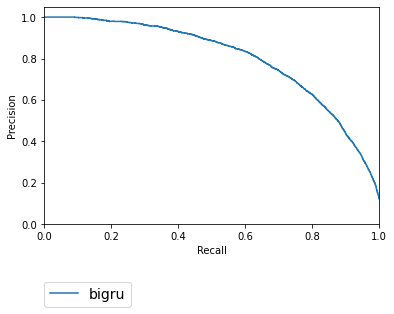

In [28]:
labels = []
labels = list(precision.keys())

plt.figure()
plt.step(recall['bigru'], precision['bigru'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(labels, loc=(0, -.38), prop=dict(size=14))